In [19]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
import yfinance as yf  # Import the yfinance module and alias it as yf

# Define the stock ticker symbol (Tesco in this case)
ticker_symbol = "TSCO"

# Set the start and end dates for the data
end_date = '2023-11-30'
start_date = '2021-01-30'

# Download historical stock data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extract the 'Adj Close' column and round the values
stock_data = stock_data['Adj Close'].round(4)

# Print or do further processing with the downloaded stock data
print(stock_data)


[*********************100%%**********************]  1 of 1 completed
Date
2021-02-01    133.1143
2021-02-02    136.4108
2021-02-03    138.0876
2021-02-04    139.3261
2021-02-05    144.3374
                ...   
2023-11-22    197.4100
2023-11-24    198.1900
2023-11-27    197.7800
2023-11-28    199.9200
2023-11-29    200.1900
Name: Adj Close, Length: 713, dtype: float64


In [21]:
# Descriptive statistice for Adjusted Closing Price
stock_data.describe()

count    713.000000
mean     201.159378
std       21.058210
min      133.114300
25%      186.056400
50%      202.312100
75%      217.629800
max      246.270400
Name: Adj Close, dtype: float64

In [22]:
# Computation of Log Returns
log_returns=np.log(stock_data/stock_data.shift(1))
log_returns

Date
2021-02-01         NaN
2021-02-02    0.024463
2021-02-03    0.012217
2021-02-04    0.008929
2021-02-05    0.035336
                ...   
2023-11-22    0.005002
2023-11-24    0.003943
2023-11-27   -0.002071
2023-11-28    0.010762
2023-11-29    0.001350
Name: Adj Close, Length: 713, dtype: float64

In [23]:
# Descriptive statistice for log returns
log_returns.describe()


count    712.000000
mean       0.000573
std        0.018227
min       -0.133738
25%       -0.008435
50%        0.000886
75%        0.011310
max        0.058581
Name: Adj Close, dtype: float64

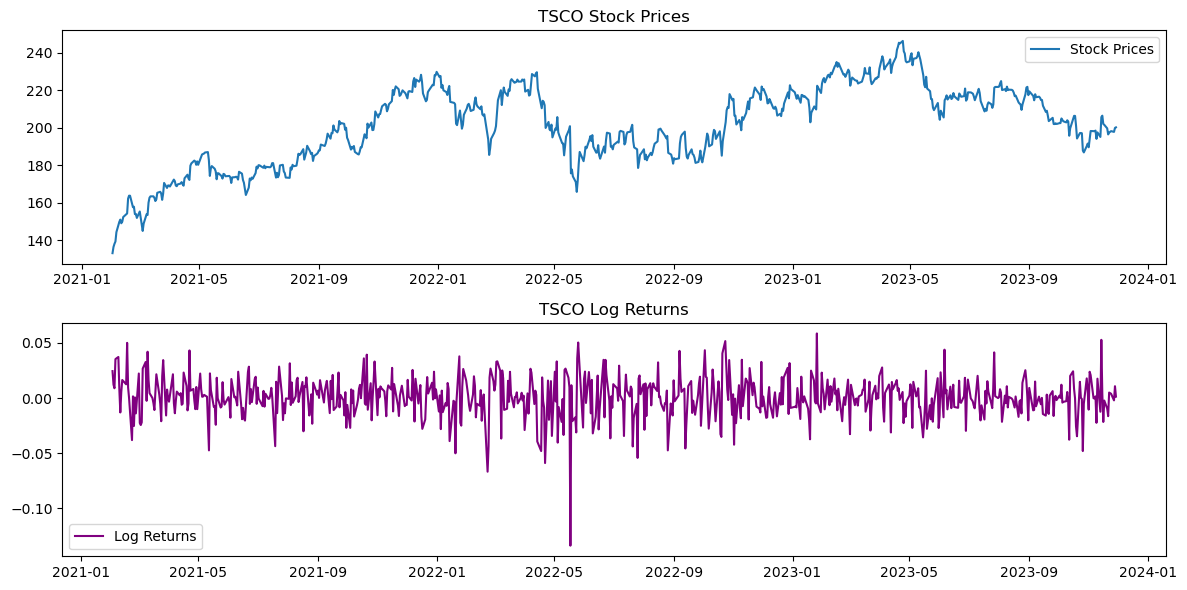

In [24]:
# Plot stock prices
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock_data, label='Stock Prices')
plt.title(f'{ticker_symbol} Stock Prices')
plt.legend()

# Plot log returns
plt.subplot(2, 1, 2)
plt.plot(log_returns, label='Log Returns', color='purple')
plt.title(f'{ticker_symbol} Log Returns')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [25]:
# Calculate annualized volatility
num_years=2
num_days=504
annualised_log_return=(1+log_returns.mean())**(1/num_years)-1
annualised_log_return

0.0002865170705130815

In [26]:
daily_volatility=log_returns.std()
annualised_volatility=daily_volatility*np.sqrt(num_days/num_years)
print(daily_volatility)
print(annualised_volatility)


0.018227149796774367
0.28934703283071883


In [27]:
# Assume a constant risk-free rate and volatility for simplicity (you may want to estimate these values more accurately)
risk_free_rate = 0.04  # 4% annual risk-free rate according to UK Bpnd Yields 
annualised_volatility=0.30


# Define the option parameters
strike_price = 220  # Example strike price
time_to_expiration = 1.0  # 30 days to expiration (you may want to adjust this)
stock_price=stock_data.iloc[-1]
stock_price

200.19

In [48]:
from scipy.stats import norm
import numpy as np

def black_scholes_merton_put(stock_price, strike_price, time_to_expiration, risk_free_rate, annualised_volatility):
    d1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * annualised_volatility**2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    d2 = d1 - annualised_volatility * np.sqrt(time_to_expiration)
    
    put_price = strike_price * np.exp(-risk_free_rate * time_to_expiration) * norm.cdf(-d2) - stock_price * norm.cdf(-d1)
    
    return put_price

# Assume constant risk-free rate and volatility
risk_free_rate = 0.04
annualised_volatility = 0.30

# Option parameters
strike_price = 220
time_to_expiration = 1.0  # In years
stock_price = stock_data.iloc[-1]  # Use the last stock price

# Calculate put price using Black-Scholes-Merton formula
put_price = black_scholes_merton_put(stock_price, strike_price, time_to_expiration, risk_free_rate, annualised_volatility)

print("Put price:", put_price)

Put price: 30.526907688931843


In [29]:
def monte_carlo(number):
    
    time_frame=int(12*time_to_expiration)
    dt= time_to_expiration/time_frame

    st_stock=np.zeros((time_frame+1,number))
    st_stock[0]=stock_price
    rn=np.random.standard_normal(st_stock.shape)

    for t in range(1,time_frame+1):
        st_stock[t]=st_stock[t-1]*np.exp((risk_free_rate-annualised_volatility**2/2)*dt+annualised_volatility*np.sqrt(dt) *rn[t])
        
    return st_stock

simulated_stocks=monte_carlo(1000)
simulated_stocks


array([[200.19      , 200.19      , 200.19      , ..., 200.19      ,
        200.19      , 200.19      ],
       [176.97179207, 200.04930892, 184.44700447, ..., 201.93402412,
        196.79443479, 207.12945678],
       [164.99323904, 211.21126437, 164.11423589, ..., 205.91976643,
        186.77124376, 207.38325084],
       ...,
       [118.47397613, 195.50108012, 134.81328226, ..., 203.54257946,
        189.44098075, 188.70389765],
       [103.22380759, 176.3299077 , 146.98753461, ..., 214.60417664,
        195.15846775, 172.47914014],
       [112.2668385 , 196.23921819, 165.3390914 , ..., 210.49754398,
        207.00738656, 204.03429116]])

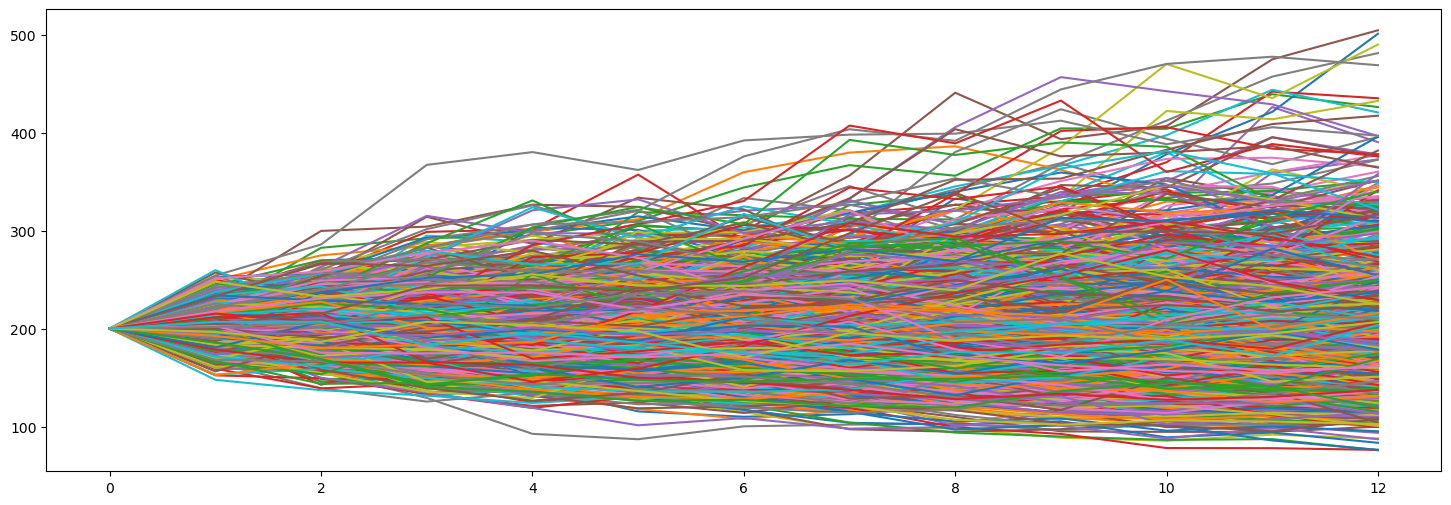

In [30]:
fig = plt.figure(figsize=(18,6))
plt.plot(simulated_stocks)
plt.show()

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

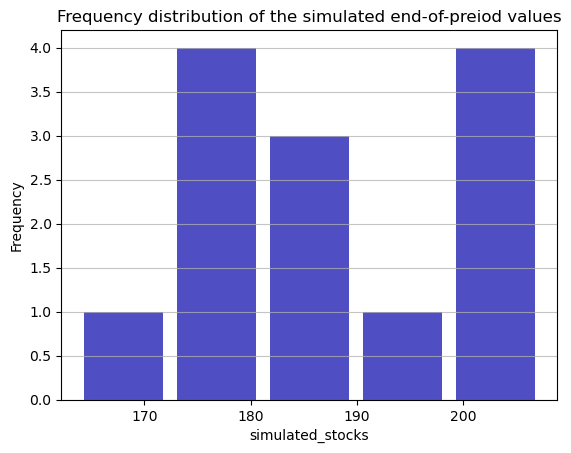

In [31]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=simulated_stocks[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('simulated_stocks')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')


In [32]:
import numpy as np

def monte_carlo(number):
   time_frame=int(12*time_to_expiration)
   dt= time_to_expiration/time_frame

   st_stock=np.zeros((time_frame+1,number)) 
   st_stock[0]=stock_price
   
   for t in range(1,time_frame+1):
       st_stock[t]=st_stock[t-1]*np.exp((risk_free_rate-annualised_volatility**2/2)*dt+annualised_volatility*np.sqrt(dt) * np.random.standard_normal(size=number)) 
       
   return st_stock
   
# Call monte carlo simulation   
simulated_stocks = monte_carlo(1000) 

strike_price = 220
time_to_expiration = 1

payoffs = np.maximum(strike_price - simulated_stocks[-1,:], 0)   

df = np.exp(-risk_free_rate * time_to_expiration)   

price = df * payoffs.mean() 

print("European Put Option Price: ", round(price, 3))

European Put Option Price:  29.747


In [33]:
from scipy.stats import norm
import numpy as np

def delta(stock_price, strike_price, time_to_expiration, risk_free_rate, annualised_volatility, payoff):
    
    d1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    delta = norm.cdf(d1, 0.0, 1.0) - 1
    
    return delta

# Example usage for a put option with a strike price of 200
stock_price = 200
strike_price_put = 220  # Updated strike price
time_to_expiration = 1.0
risk_free_rate = 0.04
annualised_volatility = 0.30

put_delta = delta(stock_price, strike_price_put, time_to_expiration, risk_free_rate, annualised_volatility, payoff="put")
print("Put Delta:", put_delta)

Put Delta: -0.5137078570096986


In [34]:
S = np.linspace(50,150,11)
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Put [i] = delta(S[i], 100, 1, 0.05, 0.25, 'put')

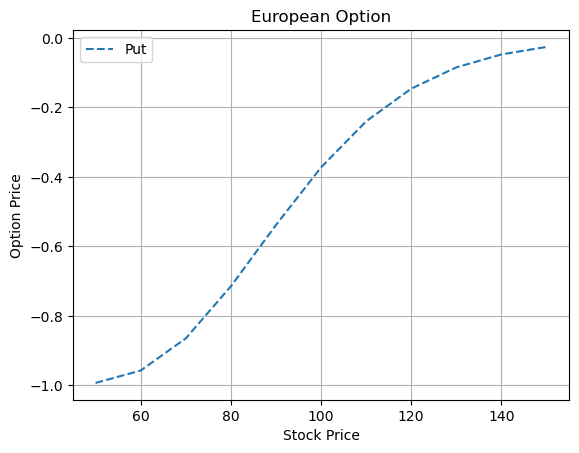

In [35]:
fig = plt.figure()
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

In [36]:
import scipy.stats as si

def gamma(Stock_price, strike_price, time_to_expiration, risk_free_rate,  annualised_volatility, payoff):
    
    d1 = (np.log(Stock_price / strike_price) + (risk_free_rate  + 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))

    gamma = si.norm.pdf(d1, 0.0, 1.0) / (annualised_volatility *  np.sqrt(time_to_expiration) * stock_price)
    return gamma

In [37]:
gamma(200, 220, 1.0, 0.04, 0.30, 'put')

0.006645112546676866

In [38]:
S = np.linspace(50,150,11)
gamma_Put = np.zeros((len(S),1))
for i in range(len(S)):
    gamma_Put [i] = gamma(S[i], 100, 1, 0.05, 0.25, 'put')

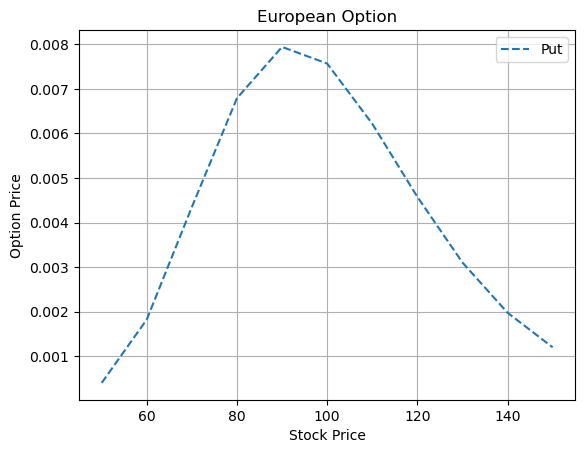

In [39]:
fig = plt.figure()
plt.plot(S, gamma_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

In [40]:
def theta(Stock_price, strike_price, time_to_expiration, risk_free_rate, annualised_volatility, payoff):
    d1 = (np.log(Stock_price / strike_price) + (risk_free_rate + 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    d2 = (np.log(Stock_price / strike_price) + (risk_free_rate - 0.5 * annualised_volatility ** 2) * time_to_expiration) / (annualised_volatility * np.sqrt(time_to_expiration))
    N_d1_prime=1/np.sqrt(2 * np.pi) * np.exp(-d1**2/2)
    theta = - Stock_price * N_d1_prime * annualised_volatility / (2 * np.sqrt(time_to_expiration)) + risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_expiration) * si.norm.cdf(-d2, 0.0, 1.0)
    return theta

In [41]:
theta(200, 220, 1.0, 0.04, 0.30, 'put')

-6.62656403709283

In [42]:
S = np.linspace(50,150,11)
theta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    theta_Put[i] = theta(S[i], 100, 1, 0.05, 0.25, 'put')

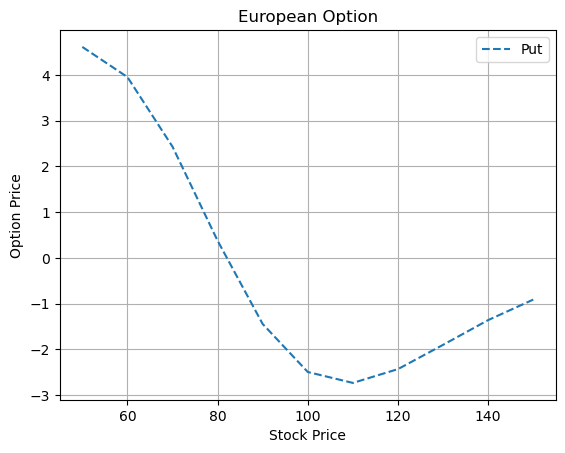

In [43]:
fig = plt.figure()
plt.plot(S, theta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

In [44]:
def rho(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [45]:
rho(200, 220, 1.0, 0.04, 0.30, 'put')

-133.3659636731382

In [46]:
S = np.linspace(50,150,11)
rho_Put = np.zeros((len(S),1))
for i in range(len(S)):
    rho_Put[i] = rho(S[i], 100, 1, 0.05, 0.25, 'put')

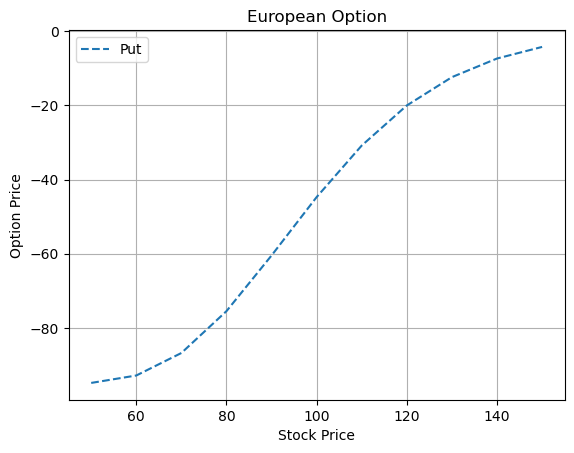

In [47]:
fig = plt.figure()
plt.plot(S, rho_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])